![Banner](https://github.com/LittleHouse75/flatiron-resources/raw/main/NevitsBanner.png)

----

# External Evaluation: DFPI Scam Wallets

----

## 1. Overview (BLUF)

**Bottom line:** A model trained only on our stitched historical Ethereum dataset still identifies **real DFPI-reported scam wallets** with strong separation (ROC AUC ≈ 0.98, AP ≈ 0.11).  

In the DFPI slice, scams are **extremely rare** (~0.02% of ~283k addresses), yet the model pushes most of them into the **extreme high-risk tail** of its scores. In other words, it has learned **portable behavioral patterns of scam activity**, not just quirks of the benchmark dataset.

Earlier notebooks asked:

- Under a **random address split** (no time drift), how well can we separate scam vs non-scam addresses?
- Under a **time-based past → future split**, how much does performance degrade when we move forward in time?

This notebook adds a third question:

> **If we train on the original benchmark dataset and then move to a separate, regulator-curated DFPI dataset,  
> do those learned patterns still help us identify likely scam wallets?**

We:

- Join DFPI-labeled addresses to our feature set  
- Apply the final tuned XGBoost model from the benchmark data *without* retraining  
- Evaluate how well it ranks DFPI scam addresses vs unlabeled neighbors

## 2. Notebook Setup & DFPI Raw Load

We reuse the same utilities and feature-engineering pipeline as the core experiments, just pointed at:
- A DFPI **transaction scrape** (scams + neighbors)
- A text file of **DFPI-reported Ethereum scam wallets**


In [11]:
# Enable autoreload so edits to src/*.py modules are picked up without restarting the kernel
%load_ext autoreload
%autoreload 2

import sys
import os
import io
import joblib

sys.path.append(os.path.abspath(".."))

import pandas as pd
from pathlib import Path
from typing import Final
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix, ConfusionMatrixDisplay

# Project-specific utilities and feature engineering
import src.utilities as util
from src.featureeng import normalize_timestamps, engineer_address_features

sns.set_style("whitegrid")

# ------------------------------------------------------------
# Resolve project root and key DFPI paths
# ------------------------------------------------------------
PROJECT_ROOT: Final[Path] = Path(util.__file__).resolve().parents[1]
print("PROJECT_ROOT:", PROJECT_ROOT)

TX_PATH = PROJECT_ROOT / "data" / "external" / "dfpi_all_deduped_txs.csv"
SCAM_PATH = PROJECT_ROOT / "data" / "external" / "dfpi_eth_scams.txt"

print("TX_PATH:", TX_PATH)
print("SCAM_PATH:", SCAM_PATH)

# ------------------------------------------------------------
# Load DFPI transaction scrape safely
# ------------------------------------------------------------
# dtype=str ensures consistent loading even with mixed columns
df = pd.read_csv(TX_PATH, dtype=str, low_memory=False)

# Align to canonical schema but only if columns exist
rename_map = {
    "from": "from_address",
    "to": "to_address",
    "gasPrice": "gas_price",
}
df = df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns})

# Keep only rows with numeric Unix timestamps
df = df[df["timeStamp"].str.fullmatch(r"\d+")]
df["timeStamp"] = df["timeStamp"].astype(int)

# Construct a proper timestamp column
df["block_timestamp"] = pd.to_datetime(df["timeStamp"], unit="s", utc=True)

# Normalize timestamps and enrich temporal features (same helper as core notebook)
df = normalize_timestamps(df, ts_col="block_timestamp", verbose=True)

# Convert numeric fields if present
numeric_cols = ["blockNumber", "value", "gas", "gas_price", "gasUsed", "confirmations"]
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Clean up isError (Etherscan can return strings)
if "isError" in df.columns:
    df["isError"] = pd.to_numeric(df["isError"], errors="coerce").fillna(0).astype(int)

util.print_heading("DFPI External Dataset — Raw Transaction Snapshot")
print(f"Rows: {len(df):,}")
print(f"Columns: {len(df.columns)}")
print(df[["block_timestamp", "from_address", "to_address"]].head())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
PROJECT_ROOT: /Users/timnevits/Projects/PythonEnv311/flatiron/project-ethereum
TX_PATH: /Users/timnevits/Projects/PythonEnv311/flatiron/project-ethereum/data/external/dfpi_all_deduped_txs.csv
SCAM_PATH: /Users/timnevits/Projects/PythonEnv311/flatiron/project-ethereum/data/external/dfpi_eth_scams.txt

----------------------------------------
Timestamp normalization
----------------------------------------

Converting `block_timestamp` into a consistent UTC datetime and adding derived features (hour, weekday).
Value types in timestamp column:
block_timestamp
<class 'pandas._libs.tslibs.timestamps.Timestamp'>    631458
Name: count, dtype: int64
Number of missing raw timestamp values: 0
Parsed timestamps (non-null): 631458
Unparseable timestamps: 0

DFPI External Dataset — Raw Transaction Snapshot

Rows: 631,458
Columns: 26
            block_timestamp                                from_address  \
0 202


## 3. DFPI Wallet Labels — Positives and Neighbors

We connect the raw DFPI scrape to our modeling labels:

- **Scam (1)** = DFPI-listed scam wallets
- **Non-scam (0)** = any address seen in the DFPI transactions that does *not* appear on the DFPI scam list  
  (victims, intermediaries, neighbors).

There is **no downsampling** of negatives here: we keep the full DFPI neighborhood, which yields a very imbalanced but realistic setting.

In [12]:
util.print_heading("DFPI Wallet Labels — Positives and Neighbors")

# Normalize all addresses to lowercase
df["from_address"] = df["from_address"].astype(str).str.lower()
df["to_address"]   = df["to_address"].astype(str).str.lower()

# Load DFPI scam addresses and normalize
with open(SCAM_PATH) as f:
    scam_addrs = [line.strip().lower() for line in f if line.strip()]

scam_addrs = sorted(set(scam_addrs))  # remove accidental duplicates
scam_set = set(scam_addrs)

# Collect every address that appears in DFPI txs
all_addrs = pd.unique(
    pd.concat([df["from_address"], df["to_address"]], ignore_index=True)
)
all_addrs = [a for a in all_addrs if isinstance(a, str)]
present_addrs = set(all_addrs)

# Candidate negatives = all addresses not in the DFPI scam list
neg_candidates = [a for a in all_addrs if a not in scam_set]

print(f"DFPI scam wallet count (file): {len(scam_addrs):,}")
print(f"Unique addresses seen in DFPI txs: {len(all_addrs):,}")
print(f"Candidate negatives (non-DFPI addresses): {len(neg_candidates):,}")

# Build DFPI label table with all negatives, then restrict to addresses we actually see
df_scam  = pd.DataFrame({"Address": scam_addrs,      "Scam": 1})
df_clean = pd.DataFrame({"Address": neg_candidates,  "Scam": 0})

addr_labels_dfpi = pd.concat([df_scam, df_clean], ignore_index=True)
addr_labels_dfpi["Address"] = addr_labels_dfpi["Address"].str.lower()
addr_labels_dfpi = addr_labels_dfpi[addr_labels_dfpi["Address"].isin(present_addrs)]
addr_labels_dfpi.reset_index(drop=True, inplace=True)

print("\nDFPI label table (after restricting to present addresses):")
print(addr_labels_dfpi["Scam"].value_counts())
print("Total DFPI-labeled addresses used:", len(addr_labels_dfpi))


DFPI Wallet Labels — Positives and Neighbors

DFPI scam wallet count (file): 59
Unique addresses seen in DFPI txs: 283,271
Candidate negatives (non-DFPI addresses): 283,213

DFPI label table (after restricting to present addresses):
Scam
0    283213
1        58
Name: count, dtype: int64
Total DFPI-labeled addresses used: 283271



## 4. DFPI Address-Level Features

We now engineer address-level features for the DFPI slice using the **same pipeline** as in the random-split experiment:

- `transaction_df = df` (DFPI transactions)
- `target_addresses = all DFPI-neighborhood addresses`
- `addr_labels = Scam / Non-scam from DFPI`
- `global_start` taken from the earliest DFPI timestamp

This yields a `features_dfpi` table that is directly compatible with the trained model.


In [13]:
util.print_heading("DFPI External — Address-Level Features")

target_addresses = addr_labels_dfpi["Address"].tolist()
global_start = df["block_timestamp_dt"].min()

features_dfpi = engineer_address_features(
    transaction_df=df,
    target_addresses=target_addresses,
    addr_labels=addr_labels_dfpi,
    global_start=global_start,
    split_label="DFPI External",
)

print("Total addresses in this split:", len(features_dfpi))
print("Total scam labels:", int(features_dfpi["Scam"].sum()))
display(features_dfpi.head())


DFPI External — Address-Level Features


Preparing Transaction Data for Feature Engineering — DFPI External

Initial row count: 631458

----------------------------------------
Numeric Column Diagnostics
----------------------------------------

value: invalid=0
gas: invalid=0
gas_price: invalid=0
Numeric cleaning complete. Rows retained: 631458

----------------------------------------
Advanced Temporal Behavior Features
----------------------------------------



/Users/timnevits/Projects/PythonEnv311/flatiron/project-ethereum/src/featureeng.py:427: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  time_metrics = long_advanced.groupby("Address").apply(_compute_time_metrics)
/Users/timnevits/Projects/PythonEnv311/flatiron/project-ethereum/src/featureeng.py:440: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  burstiness = long_advanced.groupby("Address").apply(burst)



----------------------------------------
Gas-Based Features
----------------------------------------


Aligning Features to Target Address List


----------------------------------------
Final Feature Table Sample — DFPI External
----------------------------------------



,in_degree,out_degree,unique_in_degree,unique_out_degree,Tx count,Avg amount incoming,Total amount incoming,Max amount incoming,Min amount incoming,Avg amount outgoing,...,Hour entropy,Incoming count,Outgoing count,Last seen,Activity Density,In/Out Ratio,Recency,Avg gas price,Avg gas limit,Scam
0x04e63ebfec4f1aaa8a7c05e0fb67a2855fcef589,1,1,1,1,2,1.000000e+18,1.000000e+18,1.000000e+18,1.000000e+18,1.999853e+18,...,1.000000,1,1,252654401.0,0.000064,1.000000,48990516.0,5.366186e+09,21000.000000,1
0x074580e8ad363e06a904602fac3b28bec21b2303,9,51,5,7,60,1.518195e+18,1.366375e+19,5.000000e+18,7.552758e+16,2.724367e+18,...,3.182207,9,51,213585497.0,0.000011,0.192308,88059420.0,1.992231e+10,63295.383333,1
0x09c8100e3796cc45cdf4c0c272ec65032c7b2b7f,10,25,6,2,35,2.913168e+18,2.621851e+19,1.453270e+19,9.437700e+13,3.005963e+19,...,3.415735,10,25,272892713.0,0.000005,0.423077,28752204.0,1.738338e+10,28102.857143,1
0x0bfe55cbab96ac7c9e6f2995d7be9356fc5a9639,48,49,9,4,97,8.469667e+17,4.065440e+19,3.349120e+18,1.000000e+14,5.801057e+18,...,3.654629,48,49,283904789.0,0.000003,0.980000,17740128.0,1.172868e+10,177035.092784,1
0x0cd46ee0bcec9d0b1875498404e6dfaf71afcea5,4,5,1,3,9,2.417035e+18,9.668140e+18,5.495000e+18,4.950000e+17,3.219197e+18,...,2.281036,4,5,235219553.0,0.000001,0.833333,66425364.0,4.043960e+10,180814.333333,1


Total addresses in this split: 283271
Total scam labels: 58
Total addresses in this split: 283271
Total scam labels: 58


,in_degree,out_degree,unique_in_degree,unique_out_degree,Tx count,Avg amount incoming,Total amount incoming,Max amount incoming,Min amount incoming,Avg amount outgoing,...,Hour entropy,Incoming count,Outgoing count,Last seen,Activity Density,In/Out Ratio,Recency,Avg gas price,Avg gas limit,Scam
0x04e63ebfec4f1aaa8a7c05e0fb67a2855fcef589,1,1,1,1,2,1.000000e+18,1.000000e+18,1.000000e+18,1.000000e+18,1.999853e+18,...,1.000000,1,1,252654401.0,0.000064,1.000000,48990516.0,5.366186e+09,21000.000000,1
0x074580e8ad363e06a904602fac3b28bec21b2303,9,51,5,7,60,1.518195e+18,1.366375e+19,5.000000e+18,7.552758e+16,2.724367e+18,...,3.182207,9,51,213585497.0,0.000011,0.192308,88059420.0,1.992231e+10,63295.383333,1
0x09c8100e3796cc45cdf4c0c272ec65032c7b2b7f,10,25,6,2,35,2.913168e+18,2.621851e+19,1.453270e+19,9.437700e+13,3.005963e+19,...,3.415735,10,25,272892713.0,0.000005,0.423077,28752204.0,1.738338e+10,28102.857143,1
0x0bfe55cbab96ac7c9e6f2995d7be9356fc5a9639,48,49,9,4,97,8.469667e+17,4.065440e+19,3.349120e+18,1.000000e+14,5.801057e+18,...,3.654629,48,49,283904789.0,0.000003,0.980000,17740128.0,1.172868e+10,177035.092784,1
0x0cd46ee0bcec9d0b1875498404e6dfaf71afcea5,4,5,1,3,9,2.417035e+18,9.668140e+18,5.495000e+18,4.950000e+17,3.219197e+18,...,2.281036,4,5,235219553.0,0.000001,0.833333,66425364.0,4.043960e+10,180814.333333,1


## 5. DFPI Feature Snapshot (short)

Quick sanity check on the DFPI feature table:

- **Address count:** ~283k addresses, of which **58** are DFPI scams (base rate ≈ **0.02%**).
- Scam wallets show **much higher transaction counts, value flow, and recent activity** than typical neighbors.

This matches the same **high-throughput, high-intensity behavior** we saw in the benchmark dataset and trained the model to detect.


DFPI External — Address-Level Feature Overview


----------------------------------------
Address-level shape and scam rate
----------------------------------------

Total addresses in DFPI features: 283271

Scam labels (value counts):
Scam
0    283213
1        58
Name: count, dtype: int64

Scam rate: 0.00020475092755700371


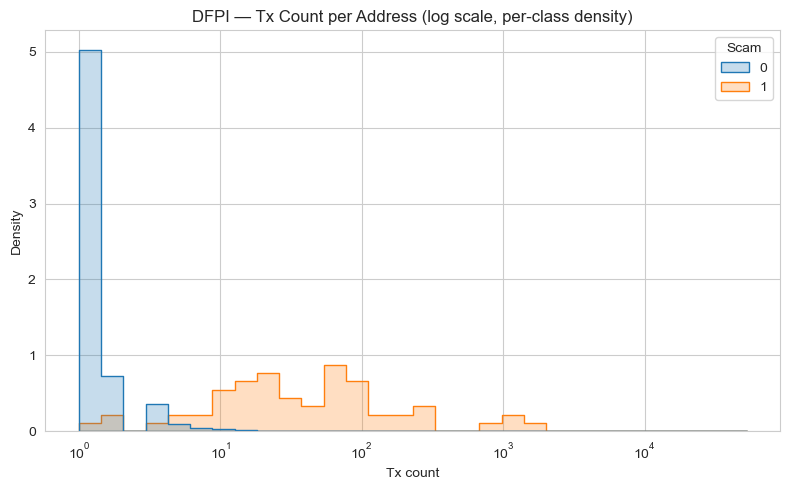

In [14]:
util.print_heading("DFPI External — Address-Level Feature Overview")

util.print_sub_heading("Address-level shape and scam rate")
print("Total addresses in DFPI features:", len(features_dfpi))
print("\nScam labels (value counts):")
print(features_dfpi["Scam"].value_counts())
print("\nScam rate:", features_dfpi["Scam"].mean())

# Simple Tx-count distribution (log scale) to show scam vs non-scam behavior
plt.figure(figsize=(8, 5))
sns.histplot(
    data=features_dfpi,
    x="Tx count",
    hue="Scam",
    bins=30,
    log_scale=True,
    multiple="layer",
    stat="density",
    common_norm=False,
    element="step",
)
plt.title("DFPI — Tx Count per Address (log scale, per-class density)")
plt.tight_layout()
plt.show()

## 6. External Evaluation — Random-Split Model on DFPI

In the random-split experiment we tuned a decision threshold of **0.66**, optimized for F1 in a much less imbalanced dataset.  
The DFPI slice is a completely different regime (base rate ≈ 0.02%), so we explicitly re-check how the model behaves at different thresholds.

Here we evaluate the model at **two thresholds**:

- **0.50** — a more lenient, recall-heavy setting  
- **0.66** — the benchmark-tuned operating point from the random-split notebook

On DFPI, both thresholds recover **~90% of known scams**, but **0.66** reduces false positives and improves precision/F1.  
For the confusion matrix and downstream discussion, we treat **0.66** as the default DFPI operating point, while noting that results are stable across nearby thresholds.


External Evaluation — Random-Split Model on DFPI

Missing feature columns in DFPI: []
Extra columns in DFPI: []

 DFPI Metrics at threshold = 0.50
Accuracy:       0.9949
Precision:      0.0350
Recall:         0.8966
F1:             0.0673
ROC AUC:        0.9836
Avg Precision:  0.1140
Confusion matrix:
[[281778   1435]
 [     6     52]]

 DFPI Metrics at threshold = 0.66
Accuracy:       0.9961
Precision:      0.0449
Recall:         0.8966
F1:             0.0855
ROC AUC:        0.9836
Avg Precision:  0.1140
Confusion matrix:
[[282107   1106]
 [     6     52]]


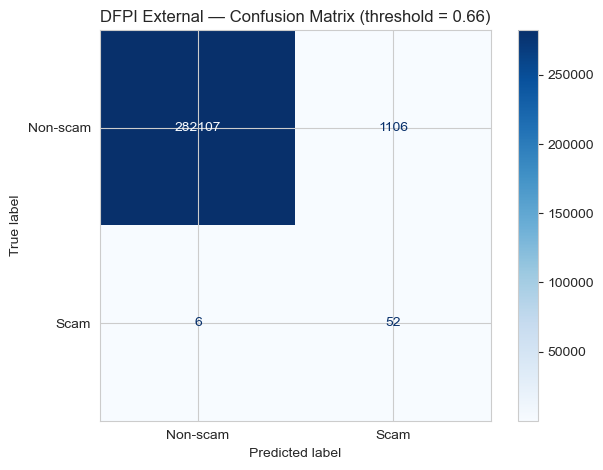

In [15]:
util.print_heading("External Evaluation — Random-Split Model on DFPI")

# Load bundle (model + feature_cols) from the random-split experiment
bundle = joblib.load("models/best_random_split_model.pkl")
model = bundle["model"]
feature_cols = bundle["feature_cols"]

# Sanity check: make sure DFPI has all the needed columns
missing = [c for c in feature_cols if c not in features_dfpi.columns]
extra   = [c for c in features_dfpi.columns if c not in feature_cols and c != "Scam"]

print("Missing feature columns in DFPI:", missing)
print("Extra columns in DFPI:", extra)

# If there are missing features, restrict to the intersection
if missing:
    feature_cols = [c for c in feature_cols if c in features_dfpi.columns]
    print("Using reduced feature_cols:", feature_cols)

X_ext = features_dfpi[feature_cols].values
y_ext = features_dfpi["Scam"].values

# Probabilities
y_ext_prob = model.predict_proba(X_ext)[:, 1]

# ------------------------------------------------------------
# Evaluate at both thresholds: 0.50 (recall-friendly) and 0.66 (benchmark-tuned)
# ------------------------------------------------------------
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, average_precision_score,
    confusion_matrix
)

def eval_dfpi_at(thr):
    y_pred = (y_ext_prob >= thr).astype(int)
    cm = confusion_matrix(y_ext, y_pred)
    return {
        "thr": thr,
        "accuracy": accuracy_score(y_ext, y_pred),
        "precision": precision_score(y_ext, y_pred, zero_division=0),
        "recall": recall_score(y_ext, y_pred, zero_division=0),
        "f1": f1_score(y_ext, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_ext, y_ext_prob),
        "avg_precision": average_precision_score(y_ext, y_ext_prob),
        "cm": cm,
    }

results = [eval_dfpi_at(t) for t in [0.50, 0.66]]

# Pretty print
for r in results:
    print("\n========================================")
    print(f" DFPI Metrics at threshold = {r['thr']:.2f}")
    print("========================================")
    print(f"Accuracy:       {r['accuracy']:.4f}")
    print(f"Precision:      {r['precision']:.4f}")
    print(f"Recall:         {r['recall']:.4f}")
    print(f"F1:             {r['f1']:.4f}")
    print(f"ROC AUC:        {r['roc_auc']:.4f}")
    print(f"Avg Precision:  {r['avg_precision']:.4f}")
    print("Confusion matrix:")
    print(r["cm"])

# ------------------------------------------------------------
# For visualization: use the 0.66 threshold (better precision, same recall)
# ------------------------------------------------------------
chosen_thr = 0.66
y_ext_pred = (y_ext_prob >= chosen_thr).astype(int)
cm = confusion_matrix(y_ext, y_ext_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Non-scam", "Scam"],
)
disp.plot(values_format="d", cmap="Blues")
plt.title(f"DFPI External — Confusion Matrix (threshold = {chosen_thr})")
plt.tight_layout()
plt.show()

### External Evaluation — Interpretation

Using the tuned random-split XGBoost model on the DFPI features:

- **ROC AUC:** ≈ **0.98**
- **Average Precision:** ≈ **0.11**  
  - Compared to a **base rate of ~0.0002**, this is a **huge lift** (hundreds of times better than random).
- **At threshold 0.66 (DFPI operating point):**
  - High **recall** (~90% of known DFPI scams found)
  - Very low **false-positive rate** (~0.4% of non-scams)
  - Precision is still modest in absolute terms (few %), but is **orders of magnitude** above the ~0.02% base rate

At **0.50**, recall is essentially the same but the false-positive rate is slightly higher;  
we keep **0.66** as the main operating point because it gives better precision and F1 for similar coverage.

Even in this noisy, ultra-imbalanced DFPI neighborhood, the model still assigns **much higher scores** to scams than to most neighbors. That’s exactly the behavior we want from a model intended to **prioritize wallets for review**, not to make fully automated blocking decisions.

## 7. Ranking Behavior — Where do DFPI scams land?

Global metrics are useful, but a fraud team really cares about **ranked lists**:

> If we sort wallets by model score and inspect the top N, how many are real scams?

In this section we:
- Compute **Precision@K** for several K values
- Visualize the **top-ranked tail** (scams vs non-scams)
- Plot the **score distribution** with DFPI scam overlay


Ranking Behavior — Precision @ K on DFPI


----------------------------------------
Top 20 DFPI addresses by model score
----------------------------------------



,Address,Scam,score
0,0x7630b16b5456075a2b8474b94e7950a917a251b9,1,0.999929
1,0xbfb77d31e16e53312bc0b1aa215d5954469615ff,0,0.999908
2,0x8190063b7e45b1a2092a39b55359b4df0277bc7a,0,0.999906
3,0xc8ab1c064c2dcd1824849683636ed83347a03ae1,0,0.999900
4,0x7da3ba256b2730f27ba8570aae9b6c83d4dd048a,0,0.999874
5,0xebbf281b9bd4f9e10e6ac81dc6984774ebd4587d,1,0.999869
6,0x905d3801ee8870a365bdf353dd00bca5079ffe69,0,0.999865
7,0x0fdbda01e3c6a3f9791cf08a130c4a8eb6d17f61,0,0.999855
8,0x37a3d486051ff1ae03a124c5ee9b10eadddcb484,0,0.999833
9,0x3e5c24518c733d02f8a2f4bf81be77aef6c12dad,0,0.999812


,K,Precision@K,Scams in top K
0,10,0.2000,2
1,25,0.2000,5
2,50,0.1600,8
3,100,0.1200,12
4,500,0.0700,35
5,1000,0.0510,51


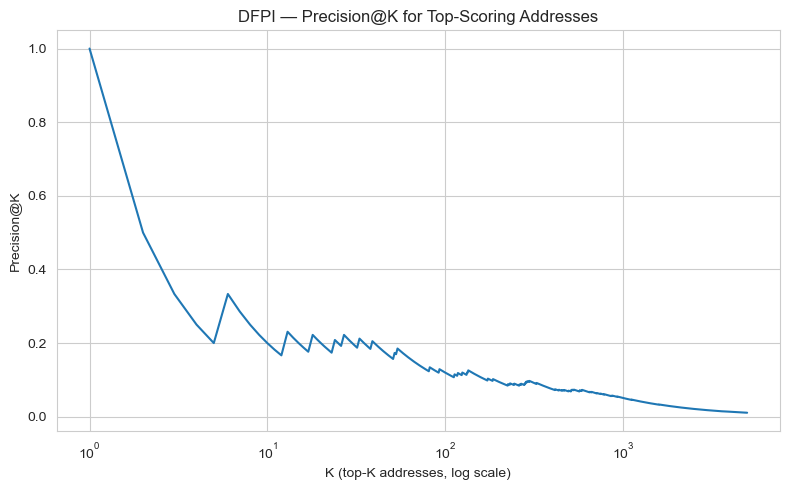

In [16]:
util.print_heading("Ranking Behavior — Precision @ K on DFPI")

# Build a scores table: one row per address with label + model score
scores_df = features_dfpi.copy()[["Scam"]].copy()
scores_df["score"] = y_ext_prob
scores_df = scores_df.reset_index().rename(columns={"index": "Address"})

# Rank by model score (descending)
scores_df = scores_df.sort_values("score", ascending=False).reset_index(drop=True)

util.print_sub_heading("Top 20 DFPI addresses by model score")
display(scores_df.head(20))

# ------------------------------------------------------------
# Precision@K for selected cutoffs
# ------------------------------------------------------------
ks = [10, 25, 50, 100, 500, 1000]

rows = []
for k in ks:
    top_k = scores_df.head(k)
    prec_k = top_k["Scam"].mean()
    rows.append({
        "K": k,
        "Precision@K": prec_k,
        "Scams in top K": int(top_k["Scam"].sum()),
    })

prec_table = pd.DataFrame(rows)
with pd.option_context("display.float_format", "{:,.4f}".format):
    display(prec_table)

# Precision curve over the first N addresses
max_k = 5000
top = scores_df.head(max_k).copy()
top["cum_scams"] = top["Scam"].cumsum()
top["k"] = np.arange(1, len(top) + 1)
top["precision_at_k"] = top["cum_scams"] / top["k"]

plt.figure(figsize=(8, 5))
plt.plot(top["k"], top["precision_at_k"])
plt.xscale("log")
plt.xlabel("K (top-K addresses, log scale)")
plt.ylabel("Precision@K")
plt.title("DFPI — Precision@K for Top-Scoring Addresses")
plt.tight_layout()
plt.show()


Top-K Risk Tail — DFPI Scams at the Extreme Right

Top-100 highest-risk addresses
Total addresses evaluated:        283,271
Overall DFPI scam rate:           0.0002
DFPI scam rate in top 100:        0.1200
DFPI scams in top 100:            12 / 100


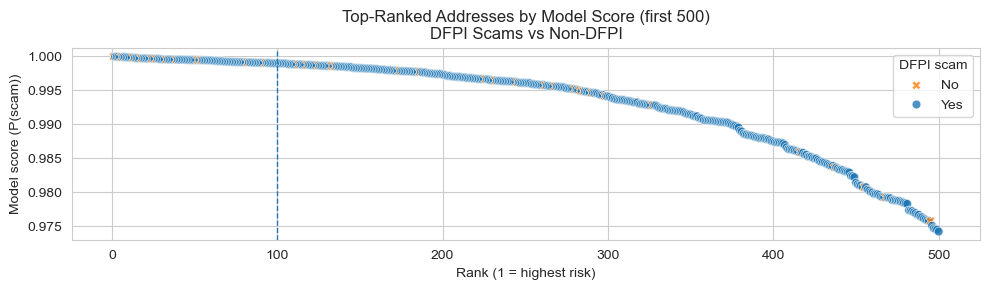

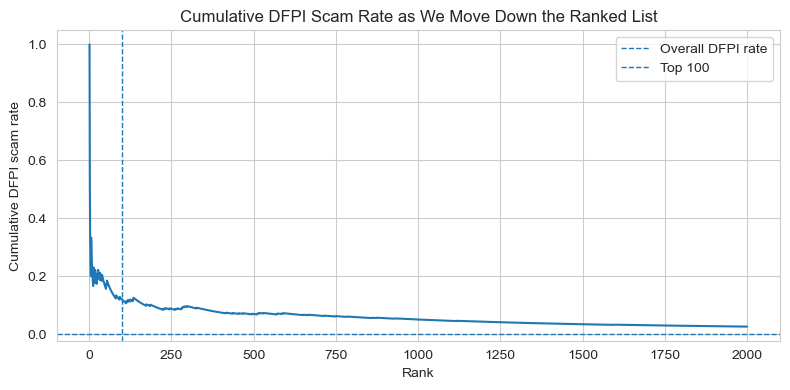

In [17]:
util.print_heading("Top-K Risk Tail — DFPI Scams at the Extreme Right")

# Build a separate df_eval for rank-based plots
df_eval = pd.DataFrame({
    "address": addr_labels_dfpi["Address"],
    "is_dfpi_scam": addr_labels_dfpi["Scam"].astype(int),
    "score": y_ext_prob,
})

df_ranked = df_eval.sort_values("score", ascending=False).reset_index(drop=True)
df_ranked["rank"] = np.arange(1, len(df_ranked) + 1)

K = 100  # top-K cutoff
top_k = df_ranked.head(K).copy()

overall_rate = df_ranked["is_dfpi_scam"].mean()
topk_rate = top_k["is_dfpi_scam"].mean()

print("========================================")
print(f"Top-{K} highest-risk addresses")
print("========================================")
print(f"Total addresses evaluated:        {len(df_ranked):,}")
print(f"Overall DFPI scam rate:           {overall_rate:.4f}")
print(f"DFPI scam rate in top {K}:        {topk_rate:.4f}")
print(f"DFPI scams in top {K}:            {top_k['is_dfpi_scam'].sum()} / {K}")
print("========================================")

# Visual 1: DFPI vs non-DFPI along the ranked tail
plt.figure(figsize=(10, 3))
sns.scatterplot(
    data=df_ranked.head(500),
    x="rank",
    y="score",
    hue="is_dfpi_scam",
    style="is_dfpi_scam",
    markers={0: "o", 1: "X"},
    s=40,
    alpha=0.8,
)
plt.axvline(K, linestyle="--", linewidth=1)
plt.title("Top-Ranked Addresses by Model Score (first 500)\nDFPI Scams vs Non-DFPI")
plt.xlabel("Rank (1 = highest risk)")
plt.ylabel("Model score (P(scam))")
plt.legend(title="DFPI scam", labels=["No", "Yes"])
plt.tight_layout()
plt.show()

# Visual 2: cumulative DFPI scam rate vs rank
df_ranked["cum_dfpi"] = df_ranked["is_dfpi_scam"].cumsum()
df_ranked["cum_rate"] = df_ranked["cum_dfpi"] / df_ranked["rank"]

plt.figure(figsize=(8, 4))
plt.plot(df_ranked["rank"].head(2000), df_ranked["cum_rate"].head(2000))
plt.axhline(overall_rate, linestyle="--", linewidth=1, label="Overall DFPI rate")
plt.axvline(K, linestyle="--", linewidth=1, label=f"Top {K}")
plt.title("Cumulative DFPI Scam Rate as We Move Down the Ranked List")
plt.xlabel("Rank")
plt.ylabel("Cumulative DFPI scam rate")
plt.legend()
plt.tight_layout()
plt.show()



Score Distribution — DFPI Scams vs Neighbors



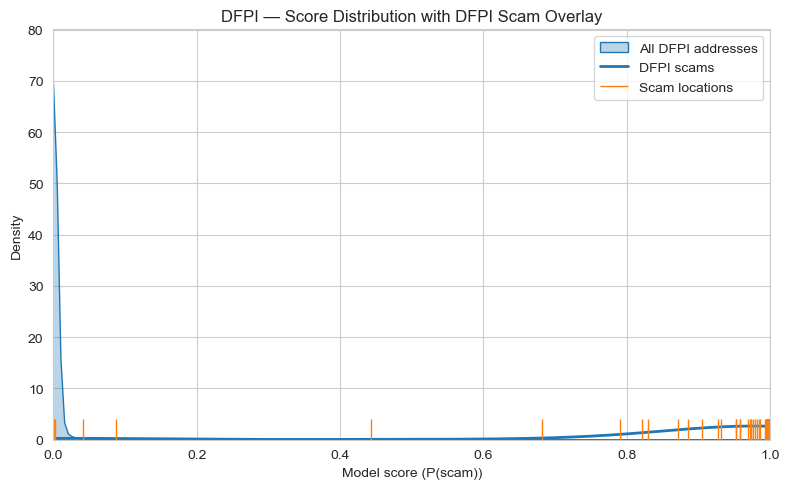

In [18]:

util.print_heading("Score Distribution — DFPI Scams vs Neighbors")

score_df = pd.DataFrame({
    "score": y_ext_prob,
    "Scam": features_dfpi["Scam"].astype(int).values,
})

scores_all  = score_df["score"]
scores_scam = score_df.loc[score_df["Scam"] == 1, "score"]

plt.figure(figsize=(8, 5))

# Overall distribution of scores
sns.kdeplot(scores_all, fill=True, alpha=0.3, label="All DFPI addresses")

# KDE for scams only (if there are enough points)
if len(scores_scam) > 1:
    sns.kdeplot(scores_scam, fill=False, linewidth=2, label="DFPI scams")

# Rug marks for scam addresses along the x-axis
sns.rugplot(scores_scam, height=0.05, linewidth=1, label="Scam locations")

plt.xlabel("Model score (P(scam))")
plt.ylabel("Density")
plt.title("DFPI — Score Distribution with DFPI Scam Overlay")
plt.xlim(0.0, 1.0)
plt.legend()
plt.tight_layout()
plt.show()

### Ranking Behavior — Interpretation

Putting the ranking views together:

- **Precision@K:**
  - Top 10–25 addresses: ~**20%** scams
  - Top 100: ~**12%** scams  
  - Top 1,000: **51 scams** (~**5.1%**), versus **~0.02%** expected at random
- **Ranked tail:**
  - DFPI scams are heavily concentrated in the **extreme right tail** of the ranked list.
  - The cumulative scam rate starts very high and decays toward the tiny background rate as we move down the ranks.
- **Score distribution:**
  - Most DFPI-neighbor addresses live at **P(scam) ≈ 0**.
  - DFPI scams cluster tightly in the **0.7–1.0** region, with very little overlap.

For a fraud team, this means:

- A **small review queue** (top few hundred or thousand addresses) is **hundreds of times richer** in scams than a random slice.
- Most known DFPI scams appear **early** in the ranked list, where human reviewers and automated rules would focus.


## 8. Final Summary — Does the model transfer?

This notebook answers a different question than the random-split and time-split experiments:

> **Does a model trained on our stitched historical dataset still detect scams in a fresh, regulator-curated slice of the chain?**

In the DFPI external evaluation:

- We scored **~283k DFPI-neighborhood addresses**, of which **58** are DFPI-reported scam wallets (base rate ≈ **0.02%**).
- The tuned random-split XGBoost model achieved:
  - **ROC AUC ≈ 0.98**
  - **Average Precision ≈ 0.11** (massive lift over the base rate)
  - **Recall ≈ 0.90** at threshold 0.66
  - **False-positive rate ≈ 0.4%** of non-scams at that same operating point
- DFPI scams are **heavily concentrated** in the extreme right tail of model scores:
  - ~**88%** of all known DFPI scams appear in the **top 1,000** addresses (top ~0.35% of the ranked list).
  - The score distribution shows scams isolated in a distinct high-risk region (0.7–1.0).

Taken together with the other experiments:

- **Random split:** How well can we separate scams under stable, no-drift conditions?
- **Time split:** How much of that signal survives when we train on the past and predict the future?
- **DFPI external:** Can the model still spot scams in a **real regulator dataset** from a **different time window** and a **scam-adjacent neighborhood**?

**Answer:** **Yes — with caveats.**  
The model is learning **portable behavioral signatures of fraud**, not just memorizing quirks of the benchmark dataset. Its scores are well-suited for **triage and prioritization** (who to review first), while final enforcement decisions would still rely on human investigation and additional signals.